## Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

import spacy
nlp = spacy.load("en_core_web_md")

import warnings
warnings.filterwarnings('ignore')

In [213]:
df = pd.read_csv("/content/IMDB Dataset.csv", nrows=50000)
print(df.shape)
df.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [214]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

## Preprocessing & Cleaning

In [217]:
sample_test = df['review'][3]
sample_test

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [218]:
def preprocess(text):
    doc = nlp(text)
    filtered_word = []
    for token in doc:
        if not token.is_stop and not token.is_punct and token.is_alpha:
            filtered_word.append(token.lemma_.lower())
    return " ".join(filtered_word)

In [219]:
preprocess(sample_test)

'basically family little boy jake think zombie closet parent fight movie slow soap opera suddenly jake decide rambo kill go film decide thriller drama drama movie watchable parent divorcing argue like real life jake closet totally ruin film expect boogeyman similar movie instead watch drama meaningless thriller play parent descent dialog shot jake ignore'

In [220]:
df['preprocessed_review'] = df['review'].apply(preprocess)
df.head(3)

,review,sentiment,preprocessed_review
0,One of the other reviewers has mentioned that ...,positive,reviewer mention watch oz episode hook right e...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production br filming techniq...
2,I thought this was a wonderful way to spend ti...,positive,think wonderful way spend time hot summer week...


In [221]:
df['preprocessed_review'][3]

'basically family little boy jake think zombie closet parent fight movie slow soap opera suddenly jake decide rambo kill go film decide thriller drama drama movie watchable parent divorcing argue like real life jake closet totally ruin film expect boogeyman similar movie instead watch drama meaningless thriller play parent descent dialog shot jake ignore'

In [222]:
df['final_text'] = "__label__"+ df['sentiment']+ " "+ df['preprocessed_review']
df['final_text'][3]

# For FastText Supervised Training the Target will be add with the begining of the training text "__Label__" + Text

'__label__negative basically family little boy jake think zombie closet parent fight movie slow soap opera suddenly jake decide rambo kill go film decide thriller drama drama movie watchable parent divorcing argue like real life jake closet totally ruin film expect boogeyman similar movie instead watch drama meaningless thriller play parent descent dialog shot jake ignore'

In [223]:
df.head()

,review,sentiment,preprocessed_review,final_text
0,One of the other reviewers has mentioned that ...,positive,reviewer mention watch oz episode hook right e...,__label__positive reviewer mention watch oz ep...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production br filming techniq...,__label__positive wonderful little production ...
2,I thought this was a wonderful way to spend ti...,positive,think wonderful way spend time hot summer week...,__label__positive think wonderful way spend ti...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake think zombie ...,__label__negative basically family little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...,__label__positive petter mattei love time mone...


## Splitting Train, Test

In [226]:
train, test = train_test_split(df, test_size = 0.2)

In [227]:
train.shape, test.shape

((40000, 4), (10000, 4))

### FastText using Supervised method for Sentiment Analysis

- To train the model we only need the text we preparing before, 'final_text' as a CSV file
- For Superviced FastText we need train and test csv for training the model & prediction  

In [228]:
train.to_csv("train_senti.csv", columns=['final_text'], header=False, index=False)
test.to_csv("test_senti.csv", columns=['final_text'], header=False, index=False)


In [229]:
model = fasttext.train_supervised(input = "train_senti.csv", epoch = 45, lr = 0.05, wordNgrams = 2)

In [230]:
model.test("test_senti.csv")



(10000, 0.8959, 0.8959)

In [231]:
model.predict('This was so bad I couldn´t finish it. The actresses are so bad at acting it feels like a bad comedy from minute one. The high rated reviews is obviously from friend/family and is pure BS.')

(('__label__negative',), array([1.00000858]))

In [232]:
model.predict('Worth watching twice, first time for the plot, second time to absorb some of the sharp dialogue.')

(('__label__positive',), array([0.9999975]))

In [233]:
model.predict('I thought the cast was great. Brianna and Emma were exceptionaly talented in thier characters.')

(('__label__negative',), array([0.98562783]))

In [234]:
model.predict("""I wanted to like this movie. I really did. But the thing is there is absolutely NOTHING to like about it lol. It's not funny, the acting is horrible, the plot is nonexistent and just nothing about this movie even makes sense. Don't waste your time with this one.""")

(('__label__negative',), array([0.99906892]))

In [235]:
model.predict("'Home Alone' has succeeded in establishing itself as a Christmas tradition, spawning off three sequels (including a made-for-television flop), and a whole franchise in and of it.")

(('__label__negative',), array([0.99517465]))

In [236]:
model.predict('The first 2 movies will always be my favourite just like for most people these movies never get old still love watching them even today')

(('__label__positive',), array([0.99945086]))

In [237]:
model.get_nearest_neighbors("watching")

[(0.9820470213890076, 'chaos'),
 (0.9812921285629272, 'great'),
 (0.9812354445457458, 'favourite'),
 (0.9810404777526855, 'definitely'),
 (0.9810246825218201, 'enjoyable'),
 (0.9809043407440186, 'sensitive'),
 (0.9808710217475891, 'cool'),
 (0.980870246887207, 'eisenstein'),
 (0.9806515574455261, 'wax'),
 (0.980586588382721, 'tarzan')]

In [238]:
model.get_nearest_neighbors("comedy")

[(0.9772838950157166, 'pleasant'),
 (0.977088987827301, 'winner'),
 (0.9770073890686035, 'bind'),
 (0.9769445061683655, 'glad'),
 (0.9767242670059204, 'sharky'),
 (0.9766753911972046, 'holly'),
 (0.9765193462371826, 'grim'),
 (0.9764215350151062, 'exciting'),
 (0.9762459397315979, 'swim'),
 (0.9762347936630249, 'eerie')]

In [239]:
model.get_nearest_neighbors("actor")

[(0.9896015524864197, 'wooden'),
 (0.9895752668380737, 'stupid'),
 (0.989567756652832, 'yell'),
 (0.9895392656326294, 'pay'),
 (0.9894558191299438, 'ridiculous'),
 (0.9893901944160461, 'bother'),
 (0.9893492460250854, 'lack'),
 (0.9892852306365967, 'drag'),
 (0.9892473816871643, 'weak'),
 (0.9891553521156311, 'uninteresting')]

### FastText using Unsupervised method for Classification

In [240]:
df.to_csv("train_final_text.csv", columns=['final_text'], header=False, index=False)

In [241]:
model_unsupervised = fasttext.train_unsupervised("train_final_text.csv", "cbow", epoch = 18, lr = 0.02, dim = 300)

In [242]:
model_unsupervised.get_nearest_neighbors('like')

[(0.6656250953674316, 'yike'),
 (0.664435088634491, 'ike'),
 (0.6189154386520386, 'lookalike'),
 (0.5971677899360657, 'nike'),
 (0.5736083388328552, 'lifelike'),
 (0.5727794170379639, 'alike'),
 (0.5551508665084839, 'liked'),
 (0.5305225253105164, 'unlike'),
 (0.5177373886108398, 'dislike'),
 (0.5125870704650879, 'liken')]

In [243]:
model_unsupervised.get_nearest_neighbors('thriller')

[(0.9034777879714966, 'thrillers'),
 (0.8115355372428894, 'thrilled'),
 (0.7806792259216309, 'driller'),
 (0.7722163200378418, 'thrill'),
 (0.7178962230682373, 'chiller'),
 (0.715603768825531, 'filler'),
 (0.7136796712875366, 'thrilling'),
 (0.7025187015533447, 'hiller'),
 (0.6769968271255493, 'diller'),
 (0.6544435620307922, 'killer')]

In [244]:
df['sentiment_num'] = df['sentiment'].map({
   'positive': 0,
   'negative': 1
})

In [245]:
df['preprocessed_review_vector'] = df['preprocessed_review'].apply(lambda x: model_unsupervised.get_word_vector(x))

In [246]:
df['preprocessed_review_vector'].head()

0    [0.115810364, -0.2121032, -0.075258695, 0.0465...
1    [0.07424301, -0.05059504, -0.09442588, 0.02871...
2    [0.0498858, -0.1081499, -0.0074336645, -0.0105...
3    [-0.030714914, -0.23271711, -0.040779263, -0.0...
4    [0.02058254, -0.13121642, -0.11790839, 0.05228...
Name: preprocessed_review_vector, dtype: object

In [247]:
x = df['preprocessed_review_vector']
y = df['sentiment_num']

x= np.stack(x)

In [249]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X = scaler.fit_transform(x)

In [250]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [251]:

clf_MNB = MultinomialNB()

clf_MNB.fit(xtrain, ytrain)
ypred_MNB = clf_MNB.predict(xtest)

train_MNB =clf_MNB.score(xtrain, ytrain)
test_MNB =clf_MNB.score(xtest, ytest)
print(f'Train Acc: {train_MNB}\nTest Acc: {test_MNB}\n\nClassification Report:\n{classification_report(ytest, ypred_MNB)} ')

Train Acc: 0.7743
Test Acc: 0.7753

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78      5000
           1       0.78      0.77      0.77      5000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000
 


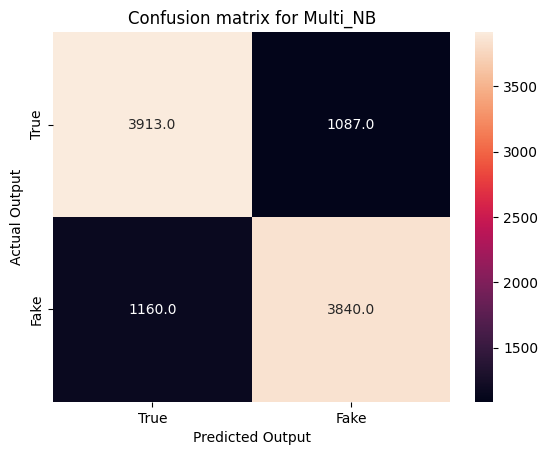

In [252]:

confusion_m =confusion_matrix(ytest, ypred_MNB)

sns.heatmap(confusion_m, annot = True, fmt = '.1f',
            xticklabels = ['True', 'Fake'],
            yticklabels = ['True', 'Fake'])
plt.xlabel('Predicted Output')
plt.ylabel('Actual Output')
plt.title("Confusion matrix for Multi_NB")
plt.show();

In [253]:
from sklearn.neighbors import KNeighborsClassifier

clf_kn = KNeighborsClassifier()

clf_kn.fit(xtrain, ytrain)
ypred_kn = clf_kn.predict(xtest)

train_kn =clf_kn.score(xtrain, ytrain)
test_kn =clf_kn.score(xtest, ytest)
print(f'Train Acc: {train_kn}\nTest Acc: {test_kn}\n\nClassification Report:\n{classification_report(ytest, ypred_kn)} ')

Train Acc: 0.864625
Test Acc: 0.8006

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      5000
           1       0.79      0.82      0.80      5000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000
 


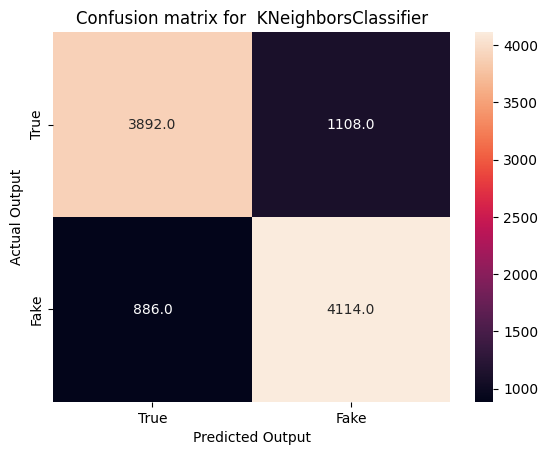

In [254]:
confusion_m =confusion_matrix(ytest, ypred_kn)

sns.heatmap(confusion_m, annot = True, fmt = '.1f',
            xticklabels = ['True', 'Fake'],
            yticklabels = ['True', 'Fake'])
plt.xlabel('Predicted Output')
plt.ylabel('Actual Output')
plt.title("Confusion matrix for  KNeighborsClassifier")
plt.show();

In [255]:

clf_rf = RandomForestClassifier()

clf_rf.fit(xtrain, ytrain)
ypred_rf = clf_rf.predict(xtest)

train_rf =clf_rf.score(xtrain, ytrain)
test_rf =clf_rf.score(xtest, ytest)
print(f'Train Acc: {train_rf}\nTest Acc: {test_rf}\n\nClassification Report:\n{classification_report(ytest, ypred_rf)} ')

Train Acc: 1.0
Test Acc: 0.8299

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      5000
           1       0.85      0.81      0.83      5000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000
 


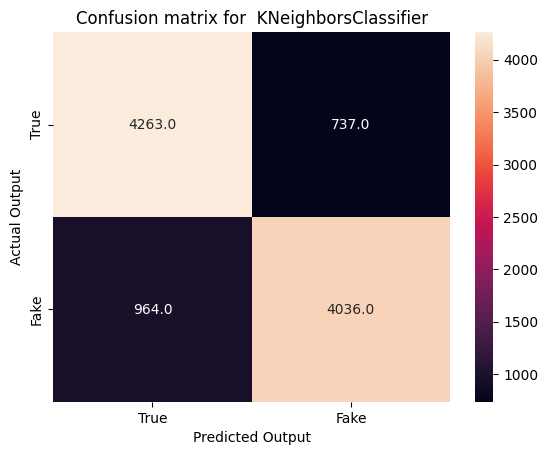

In [256]:
confusion_m =confusion_matrix(ytest, ypred_rf)

sns.heatmap(confusion_m, annot = True, fmt = '.1f',
            xticklabels = ['True', 'Fake'],
            yticklabels = ['True', 'Fake'])
plt.xlabel('Predicted Output')
plt.ylabel('Actual Output')
plt.title("Confusion matrix for  KNeighborsClassifier")
plt.show();